In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Sarcastic Datasets AI/sarcastic_headlines.csv')

In [4]:
df.head(10)

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
5,my white inheritance,0
6,5 ways to file your taxes with less stress,0
7,richard branson's global-warming donation near...,1
8,shadow government getting too large to meet in...,1
9,lots of parents know this scenario,0


In [5]:
#Shape of the Dataset
df.shape

(28619, 2)

In [6]:
#Basic Information of the Dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [7]:
#Handle Missing Values
df.isnull().sum()

,0
headline,0
is_sarcastic,0


In [8]:
#Check Duplicate Rows in Headline column
df['headline'].duplicated().sum()

116

In [9]:
#Drop Duplicates
df.drop_duplicates(subset=['headline'], inplace=True)

In [10]:
#Check Duplicates
df['headline'].duplicated().sum()

0

In [11]:
df.shape

(28503, 2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


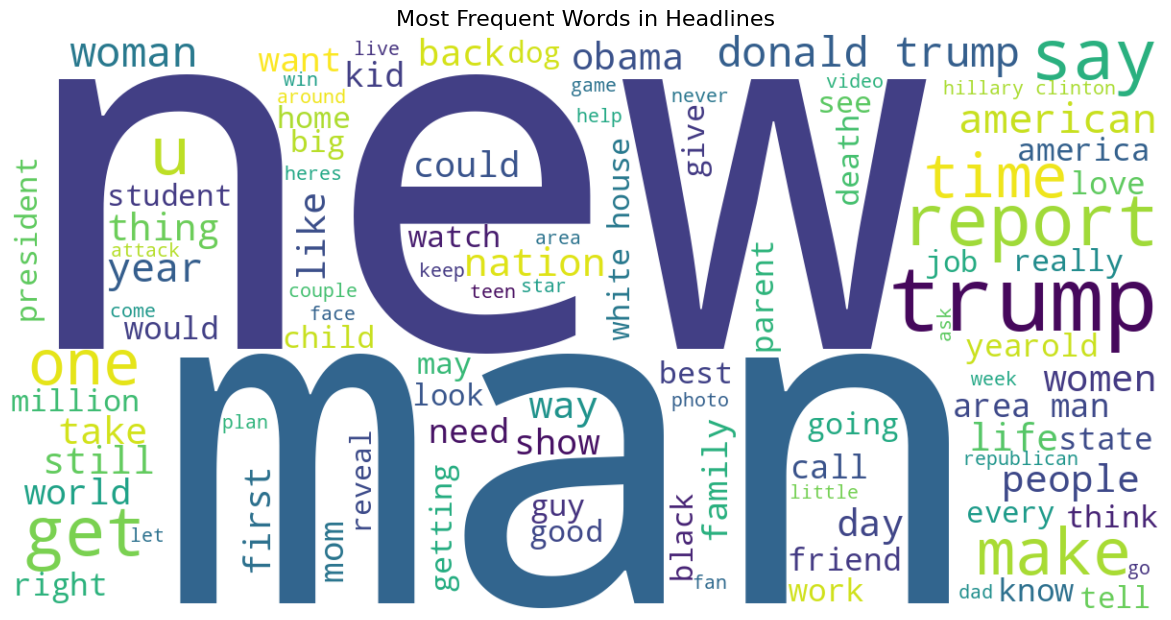

In [15]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

# Download stopwords if not already done
nltk.download('stopwords')

# Combine all raw headlines into a single string
text = " ".join(df['headline'].astype(str))
text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
text = text.lower()  # Convert to lowercase

# Use standard NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Generate the WordCloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis',
    stopwords=nltk_stopwords
).generate(text)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Headlines", fontsize=16)
plt.tight_layout(pad=0)
plt.show()


# Data Cleaning

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [13]:

example_text = "This  is  an u  EXAMPLE sentence with URLs thank  like http://example.com and mentions @user, #hashtag, punctuation! and numbers 123."
preprocessed_text = preprocess_text(example_text)
print(f"Original text: {example_text}")
print(f"Preprocessed text: {preprocessed_text}")


Original text: This  is  an u  EXAMPLE sentence with URLs thank  like http://example.com and mentions @user, #hashtag, punctuation! and numbers 123.
Preprocessed text: example sentence url thank like mention hashtag punctuation number


In [14]:

# Apply preprocess_text to the 'headline' column
df['preprocessed_headline'] = df['headline'].apply(preprocess_text)

# Print before and after for a few samples
for i in range(5):  # Print the first 5 examples
    print(f"Original text: {df['headline'][i]}")
    print(f"Preprocessed text: {df['preprocessed_headline'][i]}")
    print("---")


Original text: thirtysomething scientists unveil doomsday clock of hair loss
Preprocessed text: thirtysomething scientist unveil doomsday clock hair loss
---
Original text: dem rep. totally nails why congress is falling short on gender, racial equality
Preprocessed text: dem rep totally nail congress falling short gender racial equality
---
Original text: eat your veggies: 9 deliciously different recipes
Preprocessed text: eat veggie deliciously different recipe
---
Original text: inclement weather prevents liar from getting to work
Preprocessed text: inclement weather prevents liar getting work
---
Original text: mother comes pretty close to using word 'streaming' correctly
Preprocessed text: mother come pretty close using word streaming correctly
---


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['preprocessed_headline'], df['is_sarcastic'], test_size=0.2, random_state=42
)


In [20]:
!pip install tensorflow

In [16]:
# 3. Tokenize and Pad
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


MAX_NB_WORDS = 10000  # Maximum words to consider from tokenizer


#  Tokenization and Padding

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = min(MAX_NB_WORDS, len(word_index) + 1)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate optimal max_len using 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Optimal max_len based on 95th percentile: {max_len}")

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


Optimal max_len based on 95th percentile: 11


### A Simple RNN Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2  # fixed from keras.regularizers


#RNN MODEL
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len),
    SimpleRNN(24, kernel_regularizer=l2(0.04), recurrent_regularizer=l2(0.04)),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.build(input_shape=(None, max_len))
rnn_model.summary()

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)  # Reduced patience

# Train
rnn_history = rnn_model.fit(
    X_train_pad, y_train,

    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[checkpoint, early_stop]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 11, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 24)             │         1,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,393 (1.23 MB)

 Trainable params: 321,393 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
707/713 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5582 - loss: 1.4951
Epoch 1: val_loss improved from inf to 0.69090, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5583 - loss: 1.4904 - val_accuracy: 0.5799 - val_loss: 0.6909
Epoch 2/10
710/713 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5687 - loss: 0.6895
Epoch 2: val_loss improved from 0.69090 to 0.68181, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5687 - loss: 0.6895 - val_accuracy: 0.5799 - val_loss: 0.6818
Epoch 3/10
710/713 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5793 - loss: 0.6796
Epoch 3: val_loss improved from 0.68181 to 0.67733, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5792 - loss: 0.6797 - val_accuracy: 0.5876 - val_loss: 0.6773
Epoc

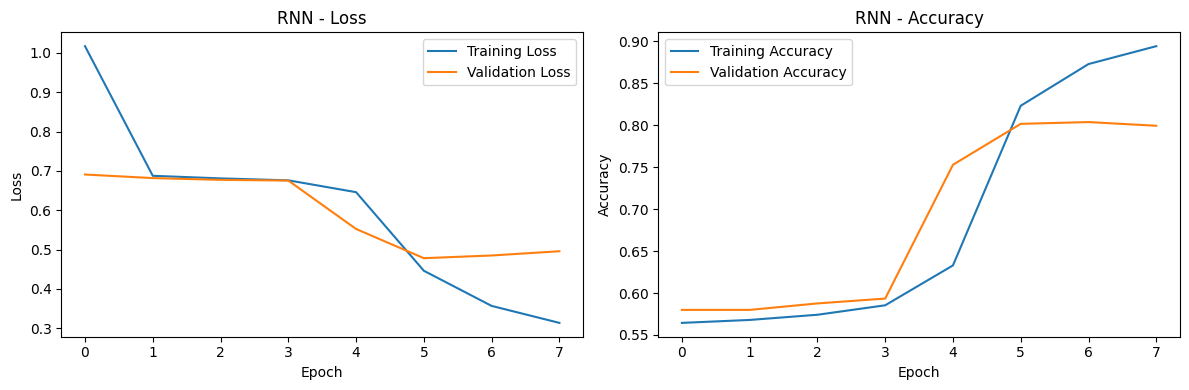

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 Accuracy: 0.8016


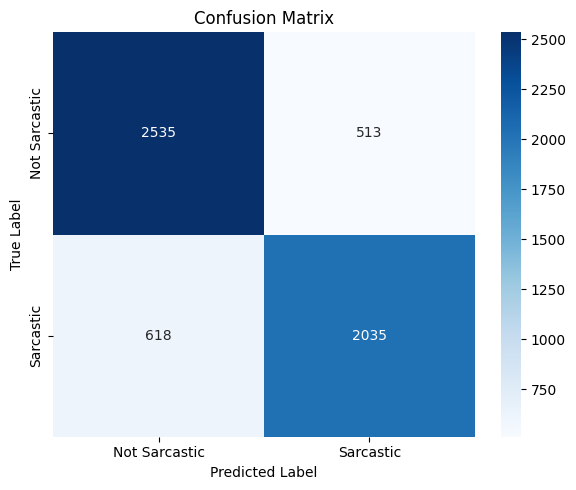


 Confusion Matrix:
[[2535  513]
 [ 618 2035]]

 Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.83      0.82      3048
    Sarcastic       0.80      0.77      0.78      2653

     accuracy                           0.80      5701
    macro avg       0.80      0.80      0.80      5701
 weighted avg       0.80      0.80      0.80      5701



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Function to plot training vs. validation loss and accuracy
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history for the RNN model
plot_history(rnn_history, 'RNN')

# ---- Evaluation ----

# Predict on test data
y_pred_probs = rnn_model.predict(X_test_pad)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\n Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred_classes, target_names=labels)
print("\n Classification Report:")
print(cr)


# Prediction for RNN Model

In [20]:
from tensorflow.keras.models import load_model
best_rnn_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras')

def predict_sarcasm(text):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = best_rnn_model.predict(padded_sequence)[0][0]
    return prediction

example_text = "Oh, look, more work to do! I definitely don’t have enough already."
prediction = predict_sarcasm(example_text)

print(f"Text: {example_text}")
print(f"Sarcasm Probability: {prediction:.4f}")
if prediction >= 0.5:
    print("Prediction: Sarcastic")
else:
    print("Prediction: Not Sarcastic")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Text: Oh, look, more work to do! I definitely don’t have enough already.
Sarcasm Probability: 0.7680
Prediction: Sarcastic


In [31]:
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

# LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# LSTM Model architecture
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(
        24,
        return_sequences=False,
        dropout=0.4,
        recurrent_dropout=0.4,
        kernel_regularizer=l2(0.02),
        recurrent_regularizer=l2(0.02)
    ),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Training
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=7,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 11, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 11, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24)             │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,497 (1.24 MB)

 Trainable params: 325,497 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6102 - loss: 1.0592
Epoch 1: val_loss improved from inf to 0.49502, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.6103 - loss: 1.0587 - val_accuracy: 0.7900 - val_loss: 0.4950
Epoch 2/7
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8309 - loss: 0.4401
Epoch 2: val_loss improved from 0.49502 to 0.44664, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8309 - loss: 0.4400 - val_accuracy: 0.8106 - val_loss: 0.4466
Epoch 3/7
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8702 - loss: 0.3549
Epoch 3: val_loss improved from 0.44664 to 0.43193, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8702 - loss: 0.3549 - val_accuracy: 0.8058 - val_loss: 0.4319

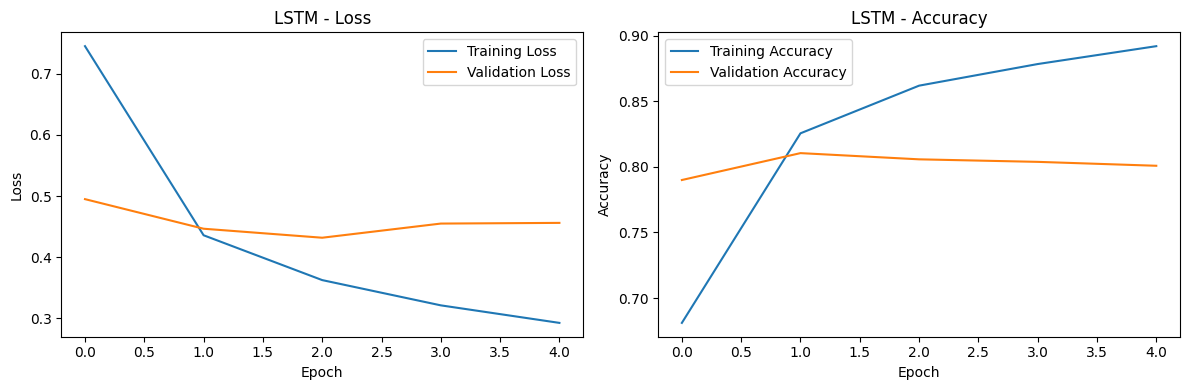

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 Accuracy: 0.8058


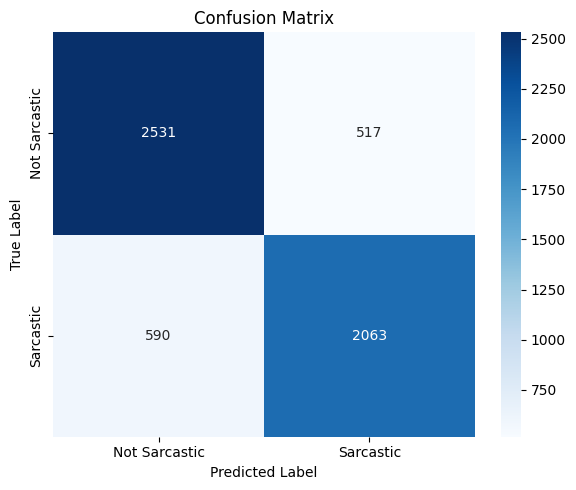


 Confusion Matrix:
[[2531  517]
 [ 590 2063]]

 Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.81      0.83      0.82      3048
    Sarcastic       0.80      0.78      0.79      2653

     accuracy                           0.81      5701
    macro avg       0.81      0.80      0.80      5701
 weighted avg       0.81      0.81      0.81      5701



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Function to plot training vs. validation loss and accuracy
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history for the LSTM model
plot_history(lstm_history, 'LSTM')

# ---- Evaluation ----

# Predict on test data
y_pred_probs = lstm_model.predict(X_test_pad)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\n Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred_classes, target_names=labels)
print("\n Classification Report:")
print(cr)


In [23]:

from tensorflow.keras.models import load_model
best_lstm_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras')

def predict_sarcasm(text):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = best_lstm_model.predict(padded_sequence)[0][0]
    return prediction


example_text = "Fantastic, I totally enjoy being stuck in traffic for hours."
prediction = predict_sarcasm(example_text)

print(f"Text: {example_text}")
print(f"Sarcasm Probability: {prediction:.4f}")
if prediction >= 0.5:
    print("Prediction: Sarcastic")
else:
    print("Prediction: Not Sarcastic")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Text: Fantastic, I totally enjoy being stuck in traffic for hours.
Sarcasm Probability: 0.7884
Prediction: Sarcastic



# LSTM WORDVEC

In [24]:
import numpy as np
from gensim.models import KeyedVectors
# Load the pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin",
binary=True)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
  if word in word2vec_model:
    embedding_matrix[index] = word2vec_model[word]

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
output_dim=embedding_dim,
weights=[embedding_matrix],
input_length=max_len,
trainable=False))
model.add(LSTM(64, dropout = 0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 11, 300)        │     6,786,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,879,505 (26.24 MB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 6,786,000 (25.89 MB)

Epoch 1/10
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6744 - loss: 0.5993
Epoch 1: val_loss improved from inf to 0.50619, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.6744 - loss: 0.5993 - val_accuracy: 0.7481 - val_loss: 0.5062
Epoch 2/10
710/713 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7412 - loss: 0.5169
Epoch 2: val_loss improved from 0.50619 to 0.47456, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.7413 - loss: 0.5169 - val_accuracy: 0.7707 - val_loss: 0.4746
Epoch 3/10
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7670 - loss: 0.4738
Epoch 3: val_loss improved from 0.47456 to 0.43726, saving model to /content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7670 - loss: 0.4738 - val_accur

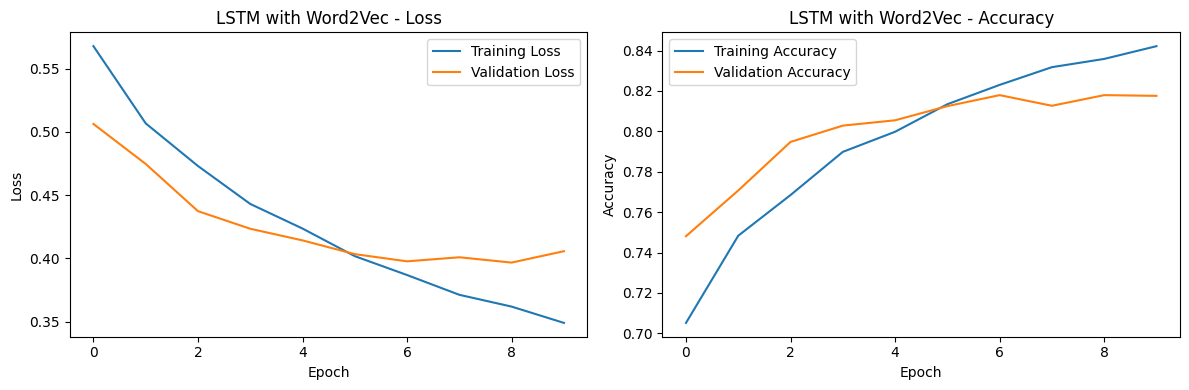

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

 Accuracy: 0.8179


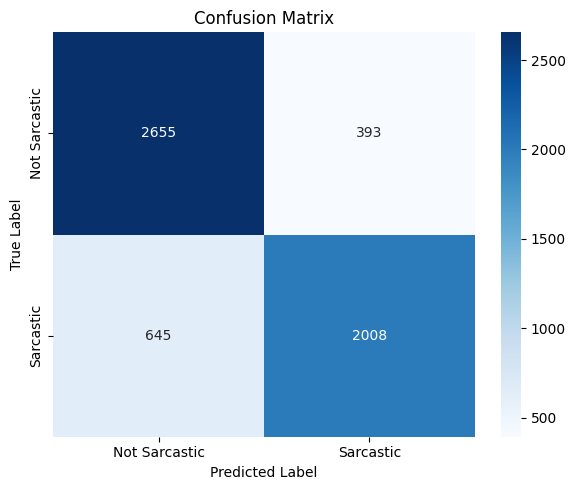


 Confusion Matrix:
[[2655  393]
 [ 645 2008]]

 Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.80      0.87      0.84      3048
    Sarcastic       0.84      0.76      0.79      2653

     accuracy                           0.82      5701
    macro avg       0.82      0.81      0.82      5701
 weighted avg       0.82      0.82      0.82      5701



In [26]:
# Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, 'LSTM with Word2Vec')

# Evaluate
y_pred_probs = model.predict(X_test_pad)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\n Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
labels = ['Not Sarcastic', 'Sarcastic']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\n Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred_classes, target_names=['Not Sarcastic', 'Sarcastic'])
print("\n Classification Report:")
print(cr)

In [27]:

# Load the best saved model
from tensorflow.keras.models import load_model
best_lstm_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras')

def predict_sarcasm(text):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = best_lstm_model.predict(padded_sequence)[0][0]
    return prediction

# Example usage
example_text = "Fantastic, I totally enjoy being stuck in traffic for hours."
prediction = predict_sarcasm(example_text)

print(f"Text: {example_text}")
print(f"Sarcasm Probability: {prediction:.4f}")
if prediction >= 0.5:
    print("Prediction: Sarcastic")
else:
    print("Prediction: Not Sarcastic")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Text: Fantastic, I totally enjoy being stuck in traffic for hours.
Sarcasm Probability: 0.6756
Prediction: Sarcastic


## Model Comparison

In [28]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [29]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")

    acc = accuracy_score(y_test, y_pred_classes)
    cm = confusion_matrix(y_test, y_pred_classes)
    cr = classification_report(y_test, y_pred_classes, target_names=['Not Sarcastic', 'Sarcastic'], output_dict=True)

    # Confusion matrix plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'],
                yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    print(f"\n{model_name} - Accuracy: {acc:.4f}")
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred_classes, target_names=['Not Sarcastic', 'Sarcastic']))

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': cr['Sarcastic']['precision'],
        'Recall': cr['Sarcastic']['recall'],
        'F1-Score': cr['Sarcastic']['f1-score']
    }


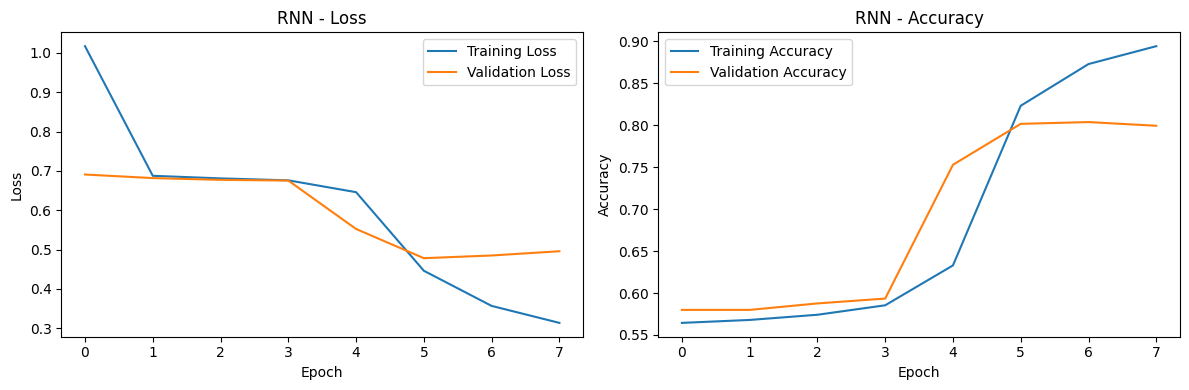

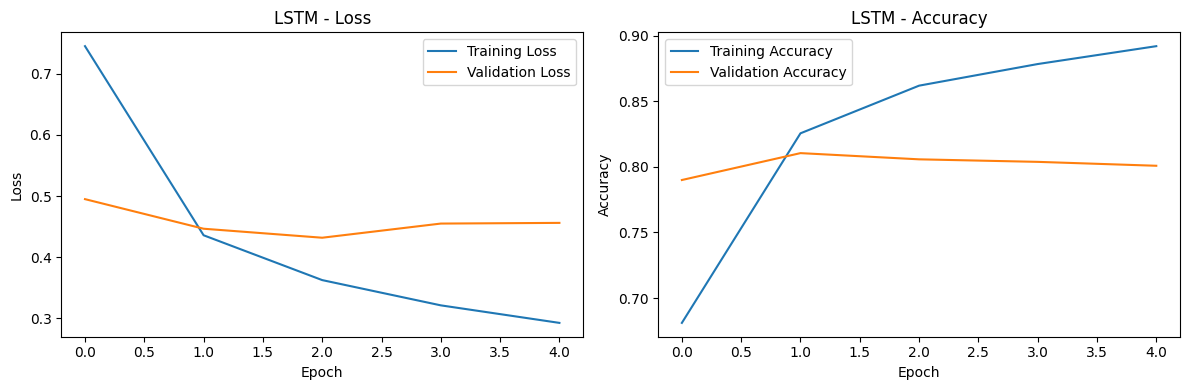

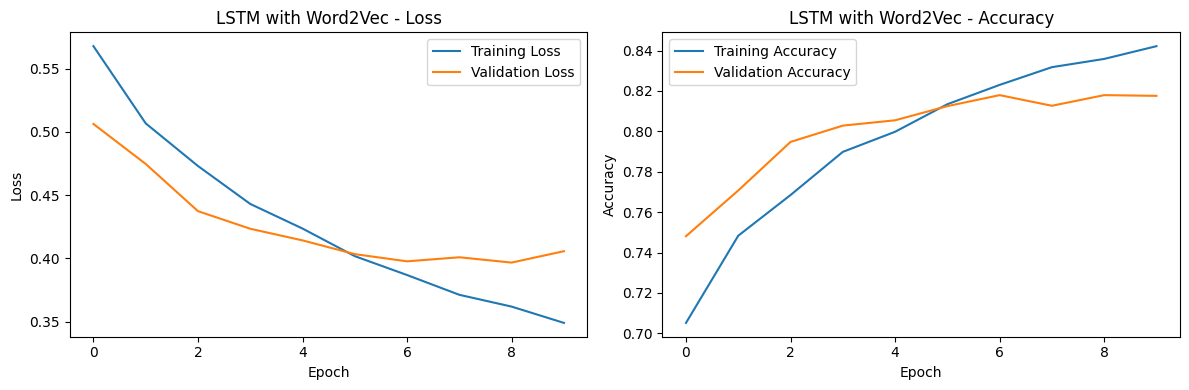

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


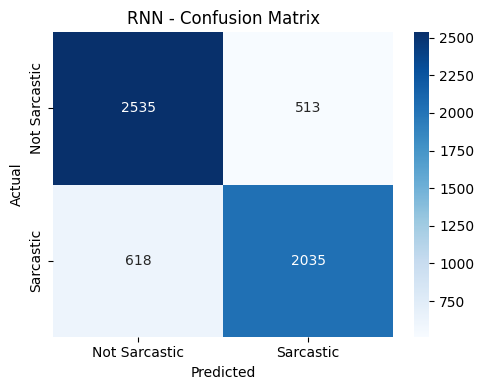


RNN - Accuracy: 0.8016

Classification Report for RNN:

               precision    recall  f1-score   support

Not Sarcastic       0.80      0.83      0.82      3048
    Sarcastic       0.80      0.77      0.78      2653

     accuracy                           0.80      5701
    macro avg       0.80      0.80      0.80      5701
 weighted avg       0.80      0.80      0.80      5701

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


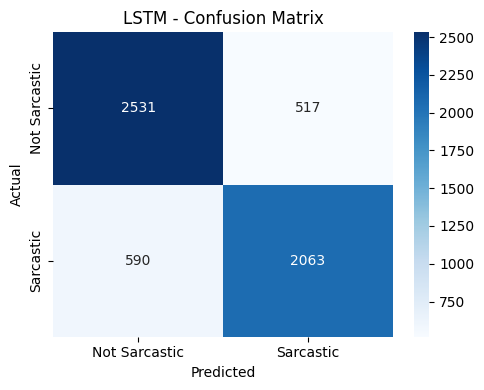


LSTM - Accuracy: 0.8058

Classification Report for LSTM:

               precision    recall  f1-score   support

Not Sarcastic       0.81      0.83      0.82      3048
    Sarcastic       0.80      0.78      0.79      2653

     accuracy                           0.81      5701
    macro avg       0.81      0.80      0.80      5701
 weighted avg       0.81      0.81      0.81      5701

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


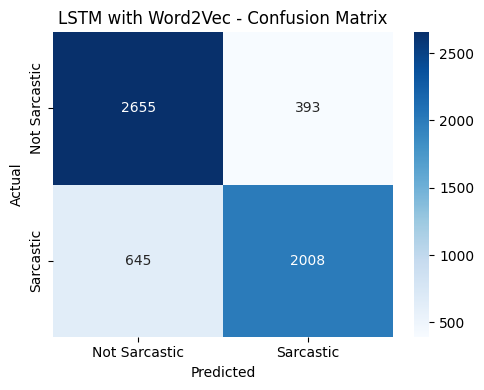


LSTM with Word2Vec - Accuracy: 0.8179

Classification Report for LSTM with Word2Vec:

               precision    recall  f1-score   support

Not Sarcastic       0.80      0.87      0.84      3048
    Sarcastic       0.84      0.76      0.79      2653

     accuracy                           0.82      5701
    macro avg       0.82      0.81      0.82      5701
 weighted avg       0.82      0.82      0.82      5701



In [30]:
# Plot training history
plot_history(rnn_history, 'RNN')
plot_history(lstm_history, 'LSTM')
plot_history(history, 'LSTM with Word2Vec')

# Evaluate each model
rnn_results = evaluate_model(rnn_model, X_test_pad, y_test, 'RNN')
lstm_results = evaluate_model(lstm_model, X_test_pad, y_test, 'LSTM')
word2vec_results = evaluate_model(model, X_test_pad, y_test, 'LSTM with Word2Vec')


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load your models (Modify paths as needed)
best_rnn_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_rnn_model.keras')
best_lstm_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_model.keras')
best_lstm_word2vec_model = load_model('/content/drive/MyDrive/Sarcasm_AI_Model/best_lstm_word2vec_model.keras')

# Use your tokenization logic
MAX_NB_WORDS = 10000  # Maximum words to consider from tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Calculate optimal max_len using 95th percentile
seq_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(X_train)]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Optimal max_len based on 95th percentile: {max_len}")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Define prediction function for Gradio
def predict_sarcasm_gradio(text, model_choice):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    if model_choice == "RNN":
        model = best_rnn_model
    elif model_choice == "LSTM":
        model = best_lstm_model
    elif model_choice == "LSTM with Word2Vec":
        model = best_lstm_word2vec_model

    prediction = model.predict(padded_sequence)[0][0]
    label = "Sarcastic" if prediction >= 0.5 else "Not Sarcastic"
    return f"Prediction: {label}\nProbability: {prediction:.4f}"

# Create Gradio interface
interface = gr.Interface(
    fn=predict_sarcasm_gradio,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter a sentence to detect sarcasm"),
        gr.Dropdown(choices=["RNN", "LSTM", "LSTM with Word2Vec"], label="Choose Model")
    ],
    outputs="text",
    title="Sarcasm Detector",
    description="Enter a sentence and the model will predict whether it's sarcastic or not."
)

# Launch interface
interface.launch(share=True)  # `share=True` generates a public link


Optimal max_len based on 95th percentile: 11
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://66a8d91cd299d65f4a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
